In [556]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# 엑셀 파일을 읽어오기
file_path = "f_rotate.xlsx"  # 실제 파일 경로로 대체
data = pd.read_excel(file_path,sheet_name=0)

In [557]:
# 초기값 설정 후 계산
initial_value = 0

# 데이터 처리
previous_shifted = data['wy(deg/s)'].shift(1, fill_value=initial_value)
current = ((previous_shifted + data['wy(deg/s)']) / 100) / 2

# 결과 계산
smoothed_average = (current.shift(1, fill_value=initial_value) + current) / 2

cumulative_smoothed = smoothed_average.shift(-1, fill_value=initial_value).cumsum()
angle_y = cumulative_smoothed.dropna()

# 최종 결과 확인
print("\nFinal angle_y:")
print(angle_y)


Final angle_y:
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2104   -2.044674
2105   -2.044674
2106   -2.044674
2107   -2.044522
2108   -2.044522
Name: wy(deg/s), Length: 2109, dtype: float64


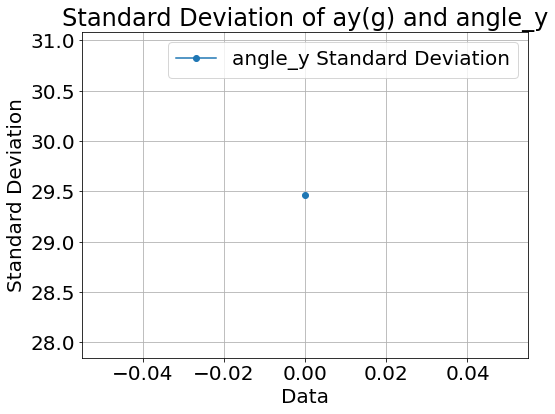

In [558]:
# 'ay(g)'와 'angle_y' 열의 표준편차 계산
angle_y_std = np.std(angle_y)

# 그래프 그리기
plt.figure(figsize=(8, 6))

# 'angle_y'의 표준편차 그래프
plt.plot(angle_y_std, label='angle_y Standard Deviation', marker='o')

plt.xlabel('Data')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of ay(g) and angle_y')
plt.legend()
plt.grid(True)
plt.show()

if angle_y_std>24:
    is_angle_y=True

In [559]:
if is_angle_y:
    src_data=angle_y.copy()
else:
    src_data=data['ay(g)']
    
# +에서 -가 되는 피크 찾기
pos_peaks, _ = find_peaks(src_data, height=-150)  # 양수 피크 찾기
neg_peaks, _ = find_peaks(-src_data, height=-120)  # 음수 피크 찾기

# 피크의 인덱스와 값을 출력
peaks = np.concatenate((pos_peaks, neg_peaks))
peaks.sort()
peak_indices = peaks + 1  # 엑셀의 행은 1부터 시작하므로 인덱스를 맞추기 위해 +1
peak_values = src_data.iloc[peaks]
peaks_df = pd.DataFrame({'Peak Index': peak_indices, 'Peak Value': peak_values})
print(peaks_df)

      Peak Index  Peak Value
45            46   -0.000915
46            47   -0.000763
49            50   -0.001220
53            54   -0.000457
57            58   -0.000609
...          ...         ...
2050        2051   -2.048182
2077        2078   -2.045284
2083        2084   -2.045742
2085        2086   -2.045437
2087        2088   -2.045742

[137 rows x 2 columns]


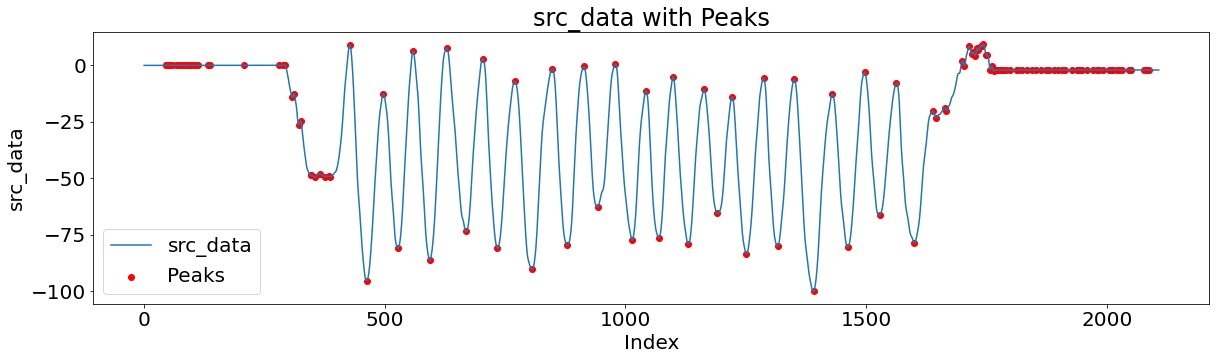

In [560]:
import matplotlib.pyplot as plt

# src_data 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(src_data, label='src_data')
plt.scatter(peaks, src_data.iloc[peaks], color='red', marker='o', label='Peaks')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Peaks')
plt.legend()
plt.show()


1
상위 이상점 기준: 39.60177426288276
하위 이상점 기준: -39.63184524082394


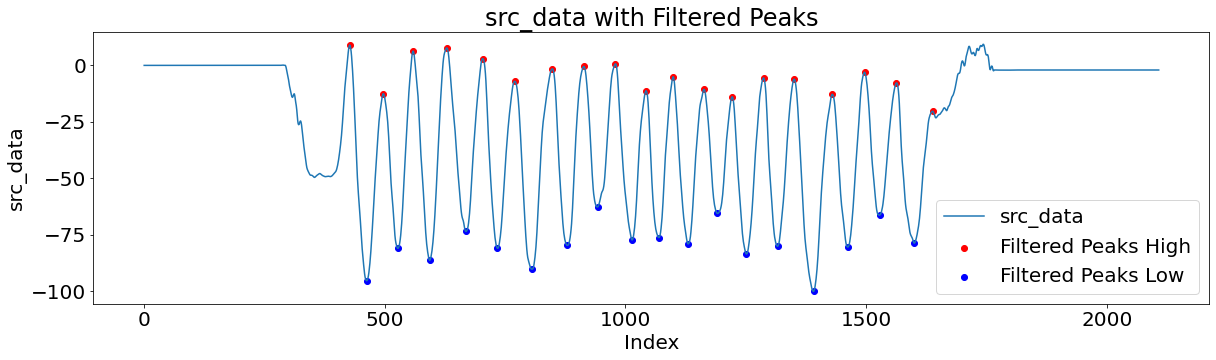

In [561]:
# 피크 간 값(value) 간격 계산
peak_values = src_data.iloc[peaks]
peak_gaps = np.diff(peak_values)

# peak_gaps의 표준 편차와 평균 계산
std_dev = np.std(peak_gaps)
mean_value = np.mean(peak_gaps)

def adjust_std_multiplier(peak_gaps):
    std_multiplier = 1  # 초기값
    while True:
        threshold_high = np.mean(peak_gaps) + std_multiplier * np.std(peak_gaps)
        outliers_count = len(peak_gaps[peak_gaps > threshold_high]) + len(peak_gaps[peak_gaps < -threshold_high])

        if outliers_count > 45:  # 이상치 수가 일정 개수 이상일 때
            std_multiplier += 0.006  # 배수를 증가시킴
        else:
            break

    return std_multiplier

# 표준 편차의 배수 자동 조정 후 임계값 계산
std_multiplier = adjust_std_multiplier(peak_gaps)
print(std_multiplier)

threshold_high = mean_value + std_multiplier * std_dev
threshold_low = mean_value - std_multiplier * std_dev

# 계산된 임계값 출력
print("상위 이상점 기준:", threshold_high)
print("하위 이상점 기준:", threshold_low)

filtered_peaks_high = peaks[np.where(peak_gaps > threshold_high)[0] + 1]
filtered_peaks_low = peaks[np.where(peak_gaps < threshold_low)[0] + 1]
filtered_peaks = peaks[np.where((peak_gaps > threshold_high) | (peak_gaps < threshold_low))[0] + 1]

filtered_peak_values = src_data.iloc[filtered_peaks]
filtered_peak_gaps = np.diff(filtered_peak_values)

# src_data 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(src_data, label='src_data')  
plt.scatter(filtered_peaks_high, src_data.iloc[filtered_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(filtered_peaks_low, src_data.iloc[filtered_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Filtered Peaks')
plt.legend()
plt.show()


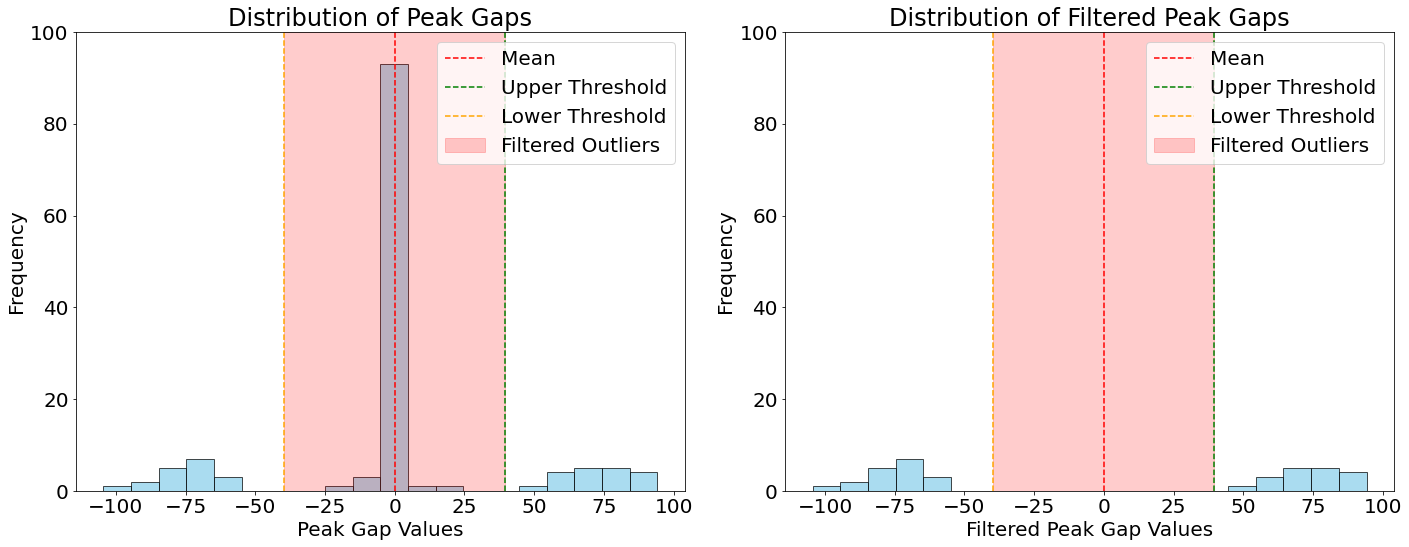

In [562]:
plt.figure(figsize=(20, 8))

# 첫 번째 서브플롯: 원래 데이터의 히스토그램
plt.subplot(1, 2, 1)
plt.hist(peak_gaps, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Peak Gap Values')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Gaps')
plt.axvline(x=mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(x=threshold_high, color='green', linestyle='--', label='Upper Threshold')
plt.axvline(x=threshold_low, color='orange', linestyle='--', label='Lower Threshold')
plt.axvspan(threshold_low, threshold_high, color='red', alpha=0.2, label='Filtered Outliers')
plt.ylim(0, 100)  # y축 범위 설정
plt.legend()

# 두 번째 서브플롯: 필터된 데이터의 히스토그램
plt.subplot(1, 2, 2)
plt.hist(filtered_peak_gaps, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Filtered Peak Gap Values')
plt.ylabel('Frequency')
plt.title('Distribution of Filtered Peak Gaps')
plt.axvline(x=mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(x=threshold_high, color='green', linestyle='--', label='Upper Threshold')
plt.axvline(x=threshold_low, color='orange', linestyle='--', label='Lower Threshold')
plt.axvspan(threshold_low, threshold_high, color='red', alpha=0.2, label='Filtered Outliers')
plt.ylim(0, 100)  # y축 범위 설정
plt.legend()

plt.tight_layout()  # 서브플롯 간 간격 조정

plt.savefig('peak_gaps_distribution_subplots.png', dpi=300)
plt.show()

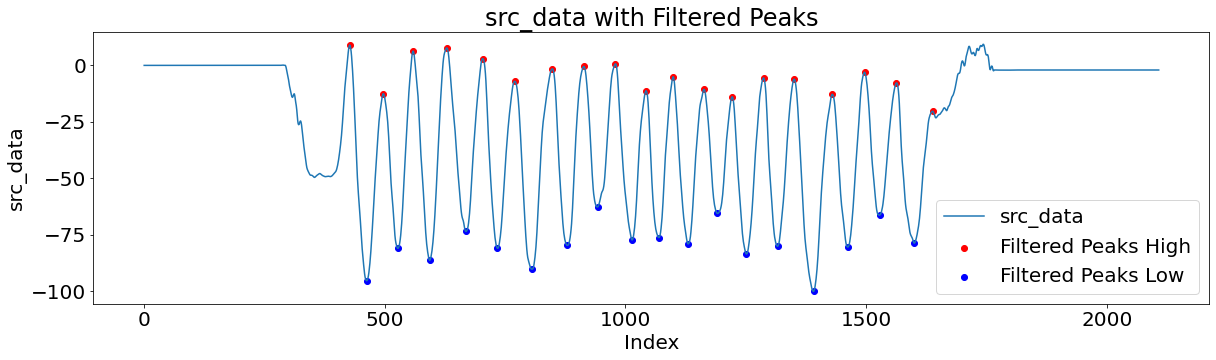

In [563]:
# 남겨질 peaks를 담을 리스트 초기화
remaining_peaks = []

# 이전 peak의 값과 인덱스 초기화
prev_peak_value = None
prev_peak_index = None


is_high = None

# high와 low를 분리할 리스트 초기화
remaining_peaks_high = []
remaining_peaks_low = []

# peaks를 순회하며 조건에 맞게 처리
for peak_index in filtered_peaks:
    # 이전 peak가 있고, 현재 peak가 이전 peak와 연속되는 경우
    is_high = peak_index in filtered_peaks_high
    curr_peak_value = src_data.iloc[peak_index]
    if prev_peak_index is not None and prev == is_high:
        # 이전 peak와 비교하여 더 큰 값을 유지
        if is_high and curr_peak_value > prev_peak_value:
            # 현재 peak가 high이고 더 큰 값이면 이전 peak를 제거하고 현재 peak로 대체
            remaining_peaks_high.remove(prev_peak_index)
            remaining_peaks_high.append(peak_index)
            prev_peak_value = curr_peak_value  # 이전 peak의 값을 갱신
        elif not is_high and curr_peak_value > prev_peak_value:
            # 현재 peak가 low이고 더 작은 값이면 이전 peak를 제거하고 현재 peak로 대체
            remaining_peaks_low.remove(prev_peak_index)
            remaining_peaks_low.append(peak_index)
            prev_peak_value = curr_peak_value  # 이전 peak의 값을 갱신
        else:
            continue  # 값이 더 작거나 크지 않은 경우, 건너뜀
    else:
        if is_high:
            remaining_peaks_high.append(peak_index)
        else:
            remaining_peaks_low.append(peak_index)
        if prev_peak_index is not None and prev != is_high and not is_high and curr_peak_value > prev_peak_value:
            remaining_peaks_high.remove(prev_peak_index)
        elif prev_peak_index is not None and prev != is_high and is_high and curr_peak_value < prev_peak_value:
            remaining_peaks_low.remove(prev_peak_index)
        else:
            # 연속되지 않는 경우에는 그대로 유지
            remaining_peaks.append(peak_index)
        prev_peak_value = src_data.iloc[peak_index]  # 이전 peak의 값을 갱신
        prev_peak_index = peak_index  # 이전 peak의 인덱스를 갱신
        prev = is_high
        # 현재 peak가 high인지 low인지에 따라 분리
        

import matplotlib.pyplot as plt

# src_data 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(src_data, label='src_data')
plt.scatter(remaining_peaks_high, src_data.iloc[remaining_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(remaining_peaks_low, src_data.iloc[remaining_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Filtered Peaks')
plt.legend()
plt.show()

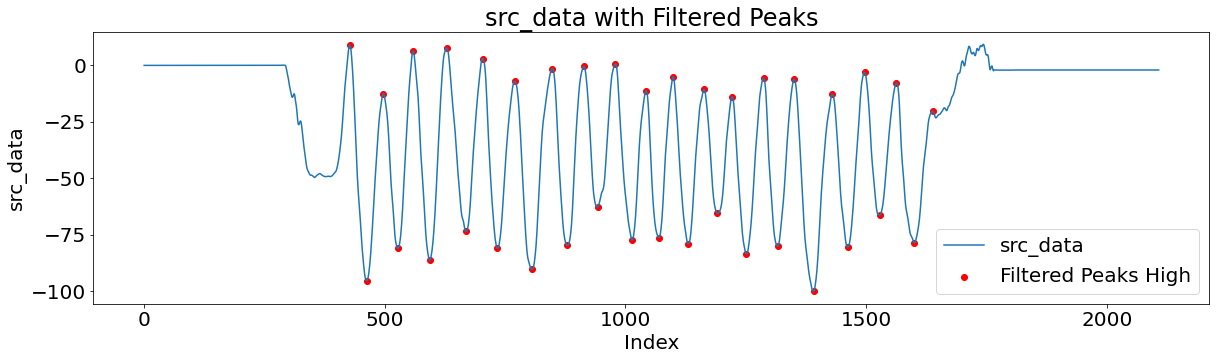

In [564]:
remaining_peaks=[]
remaining_peaks_list=remaining_peaks_high+remaining_peaks_low
remaining_peaks_high_np = np.array(remaining_peaks_high)
remaining_peaks_low_np = np.array(remaining_peaks_low)
remaining_peaks = np.concatenate((remaining_peaks_high_np,remaining_peaks_low_np))
sorted_indices = np.argsort(remaining_peaks)
remaining_peaks = remaining_peaks[sorted_indices]
peak_values = src_data.iloc[remaining_peaks]

# src_data 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(src_data, label='src_data')  
plt.scatter(remaining_peaks, src_data.iloc[remaining_peaks], color='red', marker='o', label='Filtered Peaks High')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Filtered Peaks')
plt.legend()
plt.show()

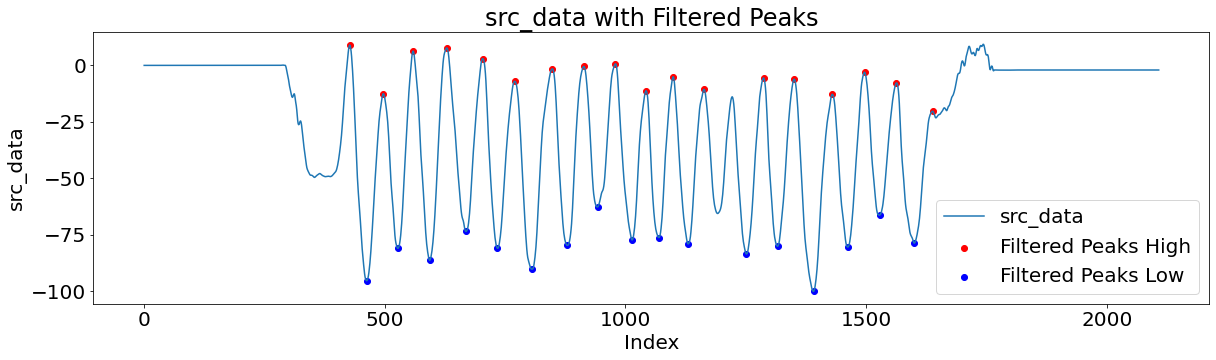

In [565]:
remaining_peaks = np.insert(remaining_peaks, 0, peaks[(np.where(peaks==remaining_peaks[0])[0])-1])
remaining_peak_values = src_data.iloc[remaining_peaks]
remaining_peak_gaps = np.diff(remaining_peak_values)

ud_threshold=58 #사용자가 필터링할 threshold(3차 필터링)
th_peaks_high = remaining_peaks[np.where(remaining_peak_gaps > ud_threshold)[0] + 1]
th_peaks_low = remaining_peaks[np.where(remaining_peak_gaps < -1*ud_threshold)[0] + 1]
th_peaks = remaining_peaks[np.where((remaining_peak_gaps > ud_threshold) | (remaining_peak_gaps < -1*ud_threshold))[0] + 1]


# src_data 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(src_data, label='src_data')  
plt.scatter(th_peaks_high, src_data.iloc[th_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(th_peaks_low, src_data.iloc[th_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Filtered Peaks')
plt.legend()
plt.show()

In [566]:
src_data.iloc[th_peaks]


if th_peaks[0] in th_peaks_low:
    print(f"low, 총 양치횟수:{len(th_peaks_low)}")
else:
    print(f"high, 총 양치횟수:{len(th_peaks_high)}")

high, 총 양치횟수:18


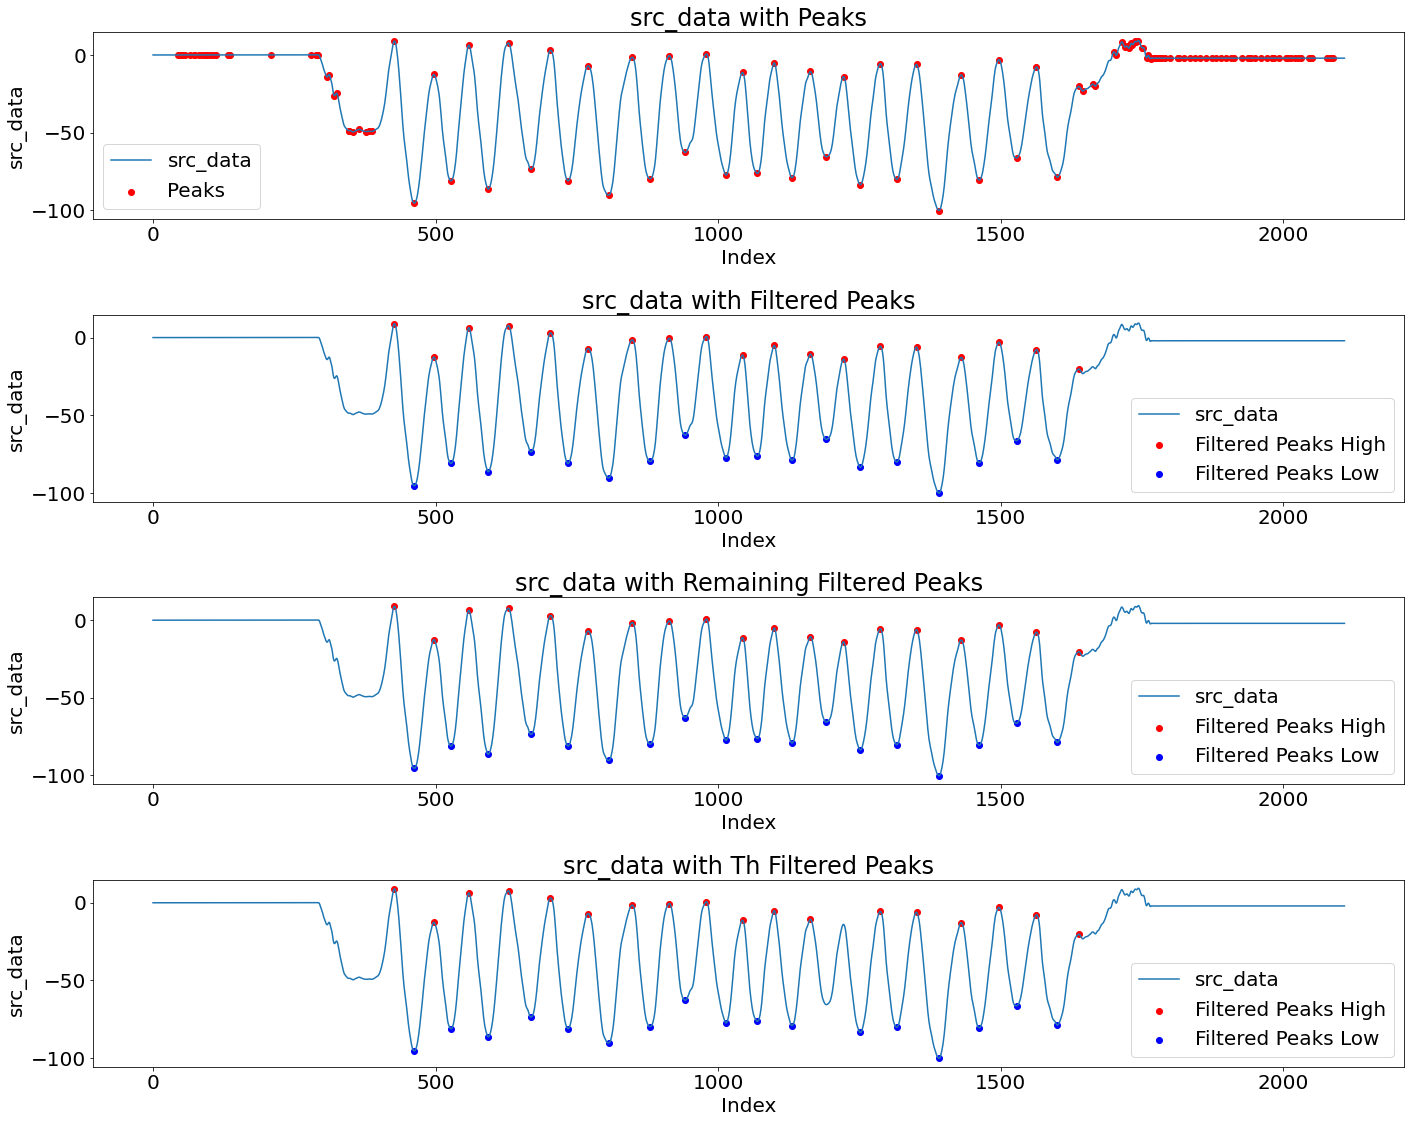

In [567]:
import matplotlib.pyplot as plt

# 세로로 subplot에 그래프 그리기
plt.figure(figsize=(20, 16))

# 첫 번째 subplot에 그래프 그리기
plt.subplot(4, 1, 1)
plt.plot(src_data, label='src_data')  
plt.scatter(peaks, src_data.iloc[peaks], color='red', marker='o', label='Peaks')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Peaks')
plt.legend()

# 두 번째 subplot에 그래프 그리기
plt.subplot(4, 1, 2)
plt.plot(src_data, label='src_data')  
plt.scatter(filtered_peaks_high, src_data.iloc[filtered_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(filtered_peaks_low, src_data.iloc[filtered_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Filtered Peaks')
plt.legend()

# 세 번째 subplot에 그래프 그리기
plt.subplot(4, 1, 3)
plt.plot(src_data, label='src_data')  
plt.scatter(remaining_peaks_high, src_data.iloc[remaining_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(remaining_peaks_low, src_data.iloc[remaining_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Remaining Filtered Peaks')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(src_data, label='src_data')  
plt.scatter(th_peaks_high, src_data.iloc[th_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(th_peaks_low, src_data.iloc[th_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('src_data')
plt.title('src_data with Th Filtered Peaks')
plt.legend()

plt.tight_layout()  # 그래프 간 간격 조정
plt.show()
